# Quick Start Examples - Hierarchical Retail Data

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:

import numpy as np
import pandas as pd
import os 
import seaborn as sns
from matplotlib import style
sns.set_context("notebook", font_scale=1.25)
style.use('fivethirtyeight')


def assign_fake_hierarchy(data, hierarchy_tuple, hierarchy_cols, target='sales'):
    data = data.copy(deep=True)
    data['hierarchy'] = [hierarchy_tuple]*len(data)
    data[hierarchy_cols] = pd.DataFrame(data['hierarchy'].tolist(), index=data.index)
    data.drop('hierarchy', axis=1, inplace=True)

    data.rename({"y":"sales", "ds":"datetime"}, axis=1, inplace=True)
    data[target] = data[target] + np.random.normal(0, data[target].std()*.2, len(data))
    data.loc[data[target] < 0, target] = 0
    data[target] = data[target].astype(int)

    # change column order
    data = data[['datetime'] + hierarchy_cols + [target]]

    return data

# help ipython find our path
directory = os.path.dirname(os.path.abspath(''))
os.chdir(directory)

import forecastframe as ff


In [3]:
# hierarchical_data = pd.read_csv("./forecastframe/sample_data/daily/small.csv") # decided to create fake data instead of using this messy hierarchical data from kaggle

data = pd.read_csv("https://raw.githubusercontent.com/facebook/prophet/master/examples/example_retail_sales.csv")

In [4]:
# create fake hierarchical retail dataset
hierarchy_cols = ['state', 'store_id', 'category', 'sku']

stores_per_state = 1
states = ('CO', 'TX', 'CA')

categories = ('FOOD', 'APPAREL')
skus_per_dept = 2

fake_hierarchy = tuple(((state, f"{state}_{store_id}", cat, f"{cat}_{sku}") for cat in categories for sku in range(skus_per_dept) for state in states for store_id in range(stores_per_state)))

df = pd.concat([assign_fake_hierarchy(data, hierarchy_tuple, hierarchy_cols=hierarchy_cols) for hierarchy_tuple in fake_hierarchy])
#df.to_csv('./forecastframe/sample_data/daily/mock_hierarchical_retail_sales.csv', index=False)

In [5]:
fframe = ff.ForecastFrame(data=df, target="sales", datetime_column="datetime", hierarchy=hierarchy_cols)

### Prophet

In [35]:
fframe.predict(model="prophet", future_periods=10, weekly_seasonality=True, daily_seasonality=True)
predictions = fframe.get_predictions(append_hierarchy_col=True)

Initial log joint probability = -7.51467
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       10013.1    0.00402474       2445.52      0.1921      0.1921      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       10083.7    0.00518523       3103.87           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       10104.1   0.000387459       296.271      0.4669      0.4669      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       10114.7   0.000702096       1314.98      0.6717      0.6717      456   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       10118.8     0.0003014       322.933      0.5572      0.5572      568   
    Iter      log prob        ||dx||      ||grad||       alpha  

In [10]:
fframe.cross_validate(folds=3, model="prophet")

Initial log joint probability = -8.29399
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2075.11    0.00284759       104.887           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     178       2075.49   1.07888e-07       78.9389      0.3673           1      237   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -8.29399
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2073.75   0.000786729       141.181           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     143       2073.98   0.000179906       147.087   1.994e-06       0.001      223  LS failed, Hessian reset 
     199       2074.02   5.68172e-05         68.27           1          

In [11]:
# check that the latest round of predictions stored in the object were created using the params found in cross-validation
assert fframe.model_object.seasonality_mode == fframe.cross_validations[-1]["best_params"]["seasonality_mode"]

In [12]:
fframe.get_cross_validation_errors()

[{'In-Sample':              Actuals    Predictions  Absolute Percent Error  Absolute Error  \
  count     879.000000     879.000000              879.000000      879.000000   
  mean   198127.676906  198112.689694                0.091133    17590.809596   
  std     32543.234590   23556.655230                0.075115    13962.591184   
  min    108599.000000  152907.181444                0.000152       23.797622   
  25%    174936.500000  179827.172488                0.036477     7442.118097   
  50%    197458.000000  198358.382090                0.072394    14249.028605   
  75%    221467.500000  216136.206306                0.125646    24487.367590   
  max    300768.000000  240155.564496                0.445174    81709.613425   
  
         Squared Error  
  count   8.790000e+02  
  mean    5.041687e+08  
  std     8.002496e+08  
  min     5.663268e+02  
  25%     5.538513e+07  
  50%     2.030348e+08  
  75%     5.996369e+08  
  max     6.676461e+09  ,
  'Out-of-Sample':           

In [13]:
fframe.save_fframe(name='prophet.pkl')

Saving to /home/nthor/forecastframe/prophet.pkl...


### LightGBM

<AxesSubplot:xlabel='datetime'>

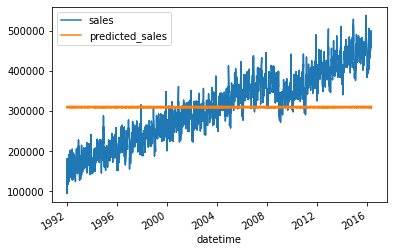

In [11]:
# Predictions are weak because our model doesn't have any features to grip on
# Note we can pass in lightgbm params as kwargs, such as learning_rate
fframe.predict(model="lightgbm", future_periods=10, learning_rate=.04)
fframe.get_predictions().plot.line()

In [12]:
# Let's add some features to help our model out
#fframe.calc_datetime_features()
fframe.lag_features(features=[fframe.target], lags=[1, 2, 3, 12]) # lagged features for 1 month ago, 2 months ago ..., 12 months ago
fframe.calc_statistical_features(features=[fframe.target], windows=[3, 6, 12], aggregations=['mean', 'std']) # 3, 6, and 12 month rolling aggregations for both mean and std
fframe.calc_ewma(fframe.target, windows=[3, 6, 12]) # 3, 6, 12 month exponential weighted moving averages

fframe.get_sample()

Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.


,state,store_id,category,sku,sales,sales_lag1,sales_lag2,sales_lag3,sales_lag12,sales_mean_roll3_lag1,sales_std_roll3_lag1,sales_mean_roll6_lag1,sales_std_roll6_lag1,sales_mean_roll12_lag1,sales_std_roll12_lag1,sales_ewma_roll3_lag1,sales_ewma_roll6_lag1,sales_ewma_roll12_lag1
datetime,,,,,,,,,,,,,,,,,,
1992-01-01,1,1,0,0,140593,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-02-01,1,1,0,0,116748,140593.0,NaN,NaN,NaN,180528.0,NaN,180528.0,NaN,180528.0,NaN,NaN,NaN,NaN
1992-03-01,1,1,0,0,181757,116748.0,140593.0,NaN,NaN,160507.0,NaN,160507.0,NaN,160507.0,NaN,NaN,NaN,NaN
1992-04-01,1,1,0,0,164187,181757.0,116748.0,140593.0,NaN,181279.0,NaN,181279.0,NaN,181279.0,NaN,157302.428571,NaN,NaN
1992-05-01,1,1,0,0,165672,164187.0,181757.0,116748.0,NaN,143548.0,NaN,143548.0,NaN,143548.0,NaN,160974.200000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2001-09-01,1,1,0,1,288230,275991.0,272368.0,311516.0,305632.0,522897.0,NaN,522897.0,NaN,522897.0,NaN,278317.260239,278523.110149,277711.693372
2001-10-01,1,1,0,1,294095,288230.0,275991.0,272368.0,283325.0,396975.0,NaN,396975.0,NaN,396975.0,NaN,283273.630119,281296.507249,279329.894397
2001-11-01,1,1,0,1,282095,294095.0,288230.0,275991.0,290270.0,393396.0,NaN,393396.0,NaN,393396.0,NaN,288684.315060,284953.219464,281601.449111


Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.


<AxesSubplot:xlabel='datetime'>

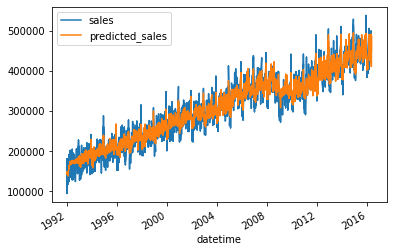

In [13]:
fframe.predict(model="lightgbm", future_periods=10, learning_rate=.04)
fframe.get_predictions().plot.line()

In [14]:
fframe.get_errors()

,Actuals,Predictions,Absolute Percent Error,Absolute Error,Squared Error
count,879.000000,879.000000,879.000000,879.000000,8.790000e+02
mean,412691.100114,330588.319640,0.193205,83566.382502,9.227961e+09
std,42439.874962,11827.830052,0.095192,47404.401665,8.948141e+09
min,290510.000000,306595.309533,0.000815,290.163072,8.419461e+04
25%,383929.500000,323160.426335,0.125382,48237.260373,2.326839e+09
50%,412228.000000,331504.778608,0.202526,83311.702292,6.940840e+09
75%,441569.000000,338267.654101,0.264361,116632.069632,1.360323e+10
max,537851.000000,356150.163072,0.416797,224174.921100,5.025440e+10


In [15]:
fframe.cross_validate(folds=3, model="lightgbm")

Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.


Running fold 1 of 3 with train shape (879, 18) and test shape (879, 18)


Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.


Running fold 2 of 3 with train shape (1758, 18) and test shape (879, 18)


KeyboardInterrupt: 

In [ ]:
fframe.save_fframe(name='lightgbm.pkl')

Saving to /home/nthor/forecastframe/forecastframe.pkl
